In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mdtraj as md
import itertools

## Chignolin (long unbiased trajectory)

### Load trajectory

In [3]:
# use external integration for large dataset (see https://docs.deepnote.com/integrations/deepnote-shared-datasets)
folder = "/datasets/chignolin-unbiased-desres/"

# load trajectory
traj_file = folder + "CLN025-0-protein-ALL.dcd"
topo_file = folder + "CLN025-0-protein.pdb"
stride = 10
traj = md.load(traj_file, top=topo_file,stride=stride)

# load reference structure (used for Root-mean-square deviation [RMSD] analysis)
ref_file = folder + "chignolin-ref-ca-DES.pdb"
ref = md.load(ref_file)

# general setup 
kbt = 2.827


In [4]:
# PRINT TOPOLOGY with atom properties (serial, name, element,residue_id,residue_name etc)
table, bonds = ref.top.to_dataframe()
table
#table.loc[table['resName'].str.contains("ASP") ]

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,N,N,1,TYR,0,
1,2,H,H,1,TYR,0,
2,3,H2,H,1,TYR,0,
3,4,H3,H,1,TYR,0,
4,5,CA,C,1,TYR,0,
...,...,...,...,...,...,...,...
161,162,HH,H,10,TYR,0,
162,163,CD2,C,10,TYR,0,
163,164,HD2,H,10,TYR,0,
164,165,CE2,C,10,TYR,0,


### Load COLVAR (aka COLlective VARiables)

In [5]:
filename=folder + 'COLVAR' 

tica1_label = 'deep.node-4'
tica2_label = 'deep.node-3'

headers = pd.read_csv(filename,sep=' ',skipinitialspace=True, nrows=0).columns[2:]
colvar = pd.read_csv(filename,sep=' ',skipinitialspace=True, header=None,skiprows=1,names=headers,comment='#')  

colvar = colvar.iloc[::stride, :]
colvar.index = np.arange(len(colvar))

colvar

,time,rmsd_ca,end,hbonds,deep.node-0,deep.node-1,deep.node-2,deep.node-3,deep.node-4
0,0.0,0.067477,0.500523,3.515683,0.156591,0.269741,-0.503362,-0.769360,0.860714
1,10.0,0.040256,0.516848,3.607478,-0.163258,0.031106,0.738618,-0.639663,0.860408
2,20.0,0.062648,0.460648,3.625588,-0.114638,0.244315,0.888992,-0.485358,0.901081
3,30.0,0.067292,0.490304,3.519522,-0.082365,-0.005303,-0.405775,-0.523814,0.901542
4,40.0,0.065588,0.487023,3.634205,0.348991,-0.240763,-0.353688,-0.586350,0.871337
...,...,...,...,...,...,...,...,...,...
52470,524700.0,0.651776,1.920228,0.413543,0.028602,0.230118,0.027031,-0.283929,-0.689612
52471,524710.0,0.543898,1.960420,0.512699,-0.170959,0.161725,-0.014535,-0.523711,-0.522852
52472,524720.0,0.428343,1.464966,0.604115,-0.156648,0.097244,0.012294,-0.381107,-0.555181
52473,524730.0,0.452596,1.448579,0.586075,-0.098890,0.154325,0.106024,-0.387451,-0.569581


In [7]:
# Calculate FES 

import scipy.stats as st

def compute_fes(colvar,xname,yname,xlim=(-1,1),ylim=(-1,1),nbins=100,max_fes=30):

    xdata = colvar[xname].values
    ydata = colvar[yname].values
    xmin, xmax = xlim
    ymin, ymax = ylim

    xgrid = np.linspace(xmin,xmax,nbins)
    ygrid = np.linspace(ymin,ymax,nbins)

    # kernel density estimation for the probability distribution
    #xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j] #why 100j? number of points along each direction
    xx,yy = np.meshgrid(xgrid,ygrid)
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([xdata, ydata])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    # free energy
    f = - kbt * np.log(f)
    f-= np.min(f)

    #if fes > max_fes set to nan
    f[f>max_fes] = np.NaN

    return f

f = compute_fes(colvar,tica1_label,tica2_label,xlim=(-1.1,1.1),ylim=(-1.1,1.1),nbins=110,max_fes=30)

In [8]:
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology

# https://stackoverflow.com/questions/3986345/how-to-find-the-local-minima-of-a-smooth-multidimensional-array-in-numpy-efficie

def detect_local_minima(arr):
    # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    # apply the local minimum filter; all locations of minimum value in their neighborhood are set to 1 http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask. we create the mask of the background
    background = (arr==0)
    # 
    # a little technicality: we must erode the background in order to successfully subtract it from local_min, otherwise a line will appear along the background border (artifact of the local minimum filter) http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, by removing the background from the local_min mask
    detected_minima = local_min ^ eroded_background
    return np.where(detected_minima)

NameError: name 'xx' is not defined

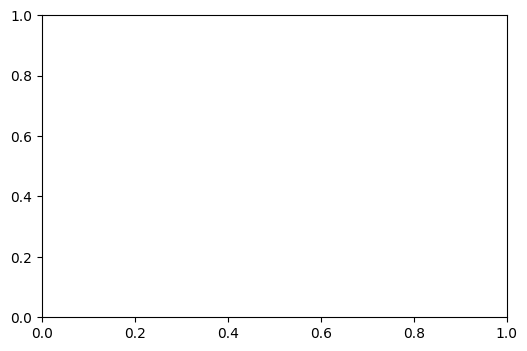

In [9]:
fig,ax = plt.subplots(dpi=100)

levels = np.arange(1,30,3)

cfset = ax.contourf(xx, yy, f, levels=levels, cmap='Blues')
#cfset = ax.imshow(np.rot90(f), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
# Contour plot
cset = ax.contour(xx, yy, f, levels=levels, colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)

cbar = plt.colorbar(cfset)
ax.set_xlabel('DeepTICA 1')
ax.set_ylabel('DeepTICA 2')
cbar.set_label('FES [kJ/mol]')

local_minima_locations = detect_local_minima(f)
for i,j in zip(*local_minima_locations):
    print(i,j,xx[i,j],yy[i,j],f[i,j])
    ax.scatter(xx[i,j],yy[i,j],marker='x',s=100)
ax.scatter(xx[i,j],yy[i,j],marker='x',s=100,label='FES local minima')
ax.legend(frameon=False,loc=2)

### Clustering -&gt; Labels

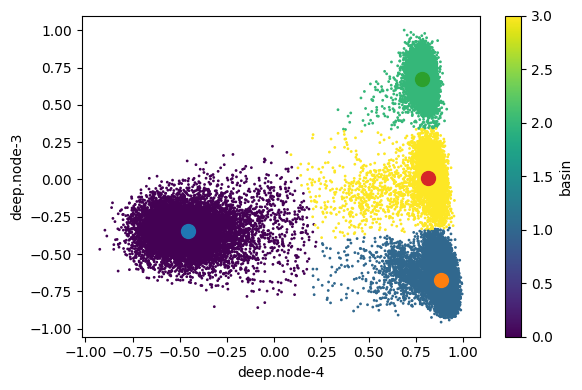

In [12]:
from sklearn.cluster import KMeans

fig, ax = plt.subplots(dpi=100)

#colvar['weights'] = np.exp( ( colvar['bias'].values - np.max(colvar['bias'].values))/kbt )

tica1 = colvar[tica1_label].values
tica2 = colvar[tica2_label].values
#weights = colvar['weights'].values

X = np.stack([tica1,tica2],axis=1)

n_clusters = 4

#init_cluster=np.asarray([[-.35,-0.35],[0.9,-.65],[0.9,0.],[.9,.65]])
#kmeans = KMeans(n_clusters=n_clusters, init=init_cluster).fit(X,sample_weight=weights)
kmeans = KMeans(n_clusters=n_clusters).fit(X)#,sample_weight=weights)
colvar['basin'] = kmeans.labels_

colvar.plot(x=tica1_label,y=tica2_label,c='basin',kind='scatter',cmap='viridis',ax=ax,s=1)

for center in kmeans.cluster_centers_:
    ax.scatter(center[0],center[1],s=100)

plt.tight_layout()

In [11]:
fes_cutoff = 5 # units kJ/mol

ref_fes = []

#compute fes values for cluster centers
for i in range(n_clusters):
    mx,my = kmeans.cluster_centers_[i]
    idx = (np.abs(xgrid - mx)).argmin()
    idy = (np.abs(ygrid - my)).argmin()
    ref_fes.append( f[idy,idx] )
ref_fes = np.asarray(ref_fes)

#compute fes values for each point
idxs = np.searchsorted(xgrid, xdata, side='left')
idys = np.searchsorted(ygrid, ydata, side='left')

fes = f[idys.tolist(),idxs.tolist()]
colvar['fes'] = fes
colvar['deltaFes'] = fes - ref_fes[colvar['basin']]

#select points whose fes w.r.t. local minimum is lesser than cutoff
colvar['selection'] = (colvar['deltaFes']<fes_cutoff).values.astype(int)

fig, ax = plt.subplots(dpi=100)
colvar.plot.scatter(tica1_label,tica2_label,c='selection',s=1,cmap='inferno',ax=ax)

NameError: name 'xgrid' is not defined

### Compute descriptors from traj

In [13]:
# COMPUTE DISTANCES
 
# https://www.mdtraj.org/1.9.5/atom_selection.html

#heavy atom distances
#basename = 'dd_'
#sel = traj.top.select('not type H')
#which is equivalent to:
#sel = [atom.index for atom in traj.top.atoms if atom.element.symbol is not 'H']

#or only CA distances
basename = 'ca_'
sel = traj.top.select('name CA')

pairs = [ (i,j) for i,j in itertools.combinations(sel,2) ]
dist = md.compute_distances(traj,pairs)
names = [basename+str(i)+'-'+str(j) for (i,j) in pairs]

df = pd.DataFrame(data=dist,columns=names)
colvar = colvar.join(df)
print(df.shape)

(52475, 45)


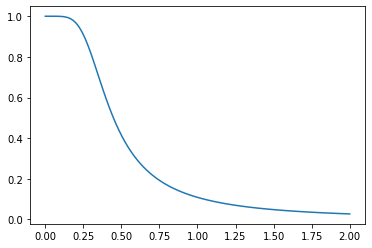

In [14]:
# CONTACT FUNCTION DEFINITION

# (see formula for RATIONAL) https://www.plumed.org/doc-v2.6/user-doc/html/switchingfunction.html
def contact_function(x,r0=1.,d0=0,n=6,m=12):
    return ( 1-np.power(((x-d0)/r0),n) ) / ( 1-np.power(((x-d0)/r0),m) )

x = np.linspace(0,2,100)
plt.plot(x, contact_function(x,r0=0.33,d0=0,n=6,m=8))
# parameters explaination:
# d0 is when the function start acting
# r0 is where the contact is equal to 0.5
# n and m determine the steepness of the contact function 

In [15]:
# H-BONDS DISTANCES / CONTACTS (donor-acceptor)

# find donors (OH or NH)
donors = [ at_i.index for at_i,at_j in traj.top.bonds  
            if ( ( at_i.element.symbol == 'O' ) | (at_i.element.symbol == 'N')  ) & ( at_j.element.symbol == 'H')]
# keep unique 
donors = sorted( list(set(donors)) )
print('Donors:',donors)

# find acceptors (O r N)
acceptors = traj.top.select('symbol O or symbol N')
print('Acceptors:',acceptors)

# compute pairs
pairs = [ (min(x,y),max(x,y)) for x in donors for y in acceptors if x != y ]
# remove duplicates
pairs = sorted(list(set(pairs)))

# compute distances
basename = 'hb_'
names = [ basename+str(x)+'-'+str(y) for x,y in  pairs]
dist = md.compute_distances(traj,pairs)
df = pd.DataFrame(data=dist,columns=names)
colvar = colvar.join(df)

# compute contacts
basename = 'hbc_'
names = [ basename+str(x)+'-'+str(y) for x,y in pairs]
contacts = contact_function(dist,r0=0.33,d0=0,n=6,m=8)
df2 = pd.DataFrame(data=contacts,columns=names)
colvar = colvar.join(df2)

df2 


Donors: [0, 15, 23, 36, 44, 70, 85, 91, 99, 106, 112, 120, 130, 147, 160]
Acceptors: [  0  15  22  23  36  43  44  52  53  55  56  69  70  81  82  84  85  91
  98  99 105 106 112 119 120 130 143 145 146 147 160]


,hbc_0-15,hbc_0-22,hbc_0-23,hbc_0-36,hbc_0-43,hbc_0-44,hbc_0-52,hbc_0-53,hbc_0-55,hbc_0-56,...,hbc_130-146,hbc_130-147,hbc_130-160,hbc_143-147,hbc_143-160,hbc_145-147,hbc_145-160,hbc_146-147,hbc_146-160,hbc_147-160
0,0.186475,0.824586,0.768259,0.090569,0.327115,0.253381,0.112789,0.098091,0.124230,0.119864,...,0.132251,0.241748,0.095374,0.948957,0.311237,0.769907,0.151569,0.725446,0.161237,0.276170
1,0.269692,0.841468,0.633849,0.083652,0.301278,0.262930,0.113015,0.115288,0.127522,0.122143,...,0.141413,0.243465,0.082819,0.940169,0.279649,0.791108,0.135401,0.795223,0.151689,0.238053
2,0.244720,0.875965,0.671065,0.096370,0.254794,0.222232,0.102523,0.092325,0.118295,0.107094,...,0.211365,0.277623,0.075319,0.945928,0.219208,0.699818,0.160710,0.871815,0.128834,0.210052
3,0.274201,0.890690,0.678030,0.083457,0.331965,0.280212,0.117071,0.123836,0.134926,0.125896,...,0.129931,0.251856,0.079819,0.950532,0.209359,0.863470,0.139162,0.670126,0.157097,0.256088
4,0.180934,0.874158,0.662796,0.088760,0.283312,0.279375,0.122685,0.112318,0.131213,0.120939,...,0.606970,0.478901,0.091405,0.941211,0.220816,0.729258,0.147097,0.817471,0.148867,0.257235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52470,0.273967,0.854729,0.656759,0.157939,0.246577,0.297032,0.117113,0.133018,0.258657,0.201482,...,0.157959,0.329683,0.640991,0.946652,0.248354,0.699092,0.143071,0.855340,0.153403,0.267490
52471,0.167643,0.703028,0.816297,0.206312,0.274832,0.529773,0.523771,0.270090,0.349478,0.211221,...,0.203028,0.477166,0.659730,0.937042,0.180363,0.800691,0.151528,0.694526,0.164823,0.252239
52472,0.181138,0.851337,0.707122,0.189557,0.249133,0.306868,0.175443,0.123292,0.292608,0.167831,...,0.168691,0.407439,0.714861,0.943211,0.210095,0.848238,0.137608,0.714285,0.151419,0.245407
52473,0.269304,0.852212,0.649308,0.228038,0.218281,0.358789,0.215903,0.176025,0.360727,0.189518,...,0.197938,0.450821,0.646930,0.935329,0.170181,0.760595,0.137469,0.820675,0.145178,0.230613


In [16]:
# DIHEDRAL ANGLES
# phi,psi --> backbone
# chi1,chi2 --> sidechain

values_list = []
names_list = []

def get_dihedrals(traj,kind='phi',sincos=True):
    #retrieve topology
    table, _ = traj.top.to_dataframe()

    #prepare list for appending
    dihedrals = []
    names,values = [],[]
    
    if kind == 'phi':
        dihedrals = md.compute_phi(traj)
    elif kind == 'psi':
        dihedrals = md.compute_psi(traj)
    elif kind == 'chi1':
        dihedrals = md.compute_chi1(traj)
    elif kind == 'chi2':
        dihedrals = md.compute_chi2(traj)
    else:
        print( 'supported values: phi,psi,chi1,chi2' )

    idx_list = dihedrals[0]
    for i, idx in enumerate(idx_list):
        #find residue id from topology table
        res = table['resSeq'][idx[0]]
        name = 'dih_'+kind+'-'+str(res)
        names.append(name)
        values.append(dihedrals[1][:,i])
        if sincos:
            names.append('cos_'+kind+'-'+str(res)) 
            values.append(np.cos( dihedrals[1][:,i] ))
            names.append('sin_'+kind+'-'+str(res)) 
            values.append(np.sin( dihedrals[1][:,i] ))
    return names, values

for kind in ['phi','psi','chi1','chi2']:
    names, values = get_dihedrals(traj,kind,sincos=True)
    names_list.extend(names)
    values_list.extend(values)

df = pd.DataFrame(data=np.asarray(values_list).T,columns=names_list)
colvar = colvar.join(df)
df
#values_list

,dih_phi-1,cos_phi-1,sin_phi-1,dih_phi-2,cos_phi-2,sin_phi-2,dih_phi-3,cos_phi-3,sin_phi-3,dih_phi-4,...,sin_chi2-4,dih_chi2-5,cos_chi2-5,sin_chi2-5,dih_chi2-9,cos_chi2-9,sin_chi2-9,dih_chi2-10,cos_chi2-10,sin_chi2-10
0,-2.802378,-0.943016,-0.332746,-1.961929,-0.381236,-0.924478,-1.129399,0.427204,-0.904155,-1.044915,...,-0.390129,-3.130611,-0.999940,-0.010981,1.669662,-0.098705,0.995117,1.579886,-0.009089,0.999959
1,-1.647477,-0.076605,-0.997061,-1.612325,-0.041517,-0.999138,-1.339162,0.229569,-0.973292,-1.404712,...,-0.521585,1.410696,0.159417,0.987211,1.978097,-0.396132,0.918193,1.935033,-0.356236,0.934396
2,-2.312177,-0.675307,-0.737537,-2.146757,-0.544640,-0.838670,-0.954109,0.578336,-0.815799,-1.239787,...,0.499438,2.866122,-0.962297,0.272000,-1.557036,0.013760,-0.999905,1.786988,-0.214512,0.976721
3,-1.280259,0.286467,-0.958090,-1.833037,-0.259246,-0.965811,-1.094865,0.458167,-0.888866,-1.420681,...,-0.618962,-3.060344,-0.996701,-0.081159,-1.894972,-0.318527,-0.947914,1.905820,-0.328791,0.944403
4,-1.916033,-0.338420,-0.940995,-1.413374,0.156773,-0.987635,-1.319649,0.248516,-0.968628,-1.191379,...,-0.287387,2.995318,-0.989321,0.145753,-1.116294,0.439016,-0.898479,1.567960,0.002836,0.999996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52470,-1.855256,-0.280639,-0.959813,-1.801870,-0.229023,-0.973421,-1.434898,0.135481,-0.990780,-1.464028,...,-0.726667,-2.817555,-0.947957,-0.318397,1.625115,-0.054292,0.998525,-0.802685,0.694778,-0.719224
52471,-1.545336,0.025458,-0.999676,-1.676052,-0.105062,-0.994466,-1.191619,0.370156,-0.928970,-1.188391,...,-0.478439,-2.803253,-0.943307,-0.331921,1.700710,-0.129549,0.991573,-1.010977,0.531033,-0.847351
52472,-1.493065,0.077653,-0.996980,-0.979568,0.557382,-0.830256,-1.172225,0.388103,-0.921616,-1.114608,...,-0.624779,2.842788,-0.955689,0.294378,1.490473,0.080237,0.996776,-0.654335,0.793453,-0.608632
52473,-1.614367,-0.043557,-0.999051,-1.999589,-0.415773,-0.909468,-1.033706,0.511638,-0.859201,-1.650120,...,0.531599,3.085804,-0.998444,0.055760,1.629964,-0.059133,0.998250,-0.893910,0.626369,-0.779527


### Compute properties (optional)

In [17]:
# RMSD analysis w.r.t. experimental NMR structure, using only CA atoms

#rmsd = md.rmsd(traj,ref,atom_indices=ref.top.select('name CA'))

#plt.figure()
#plt.plot(rmsd)

### Perform H-bonds analysis

In [18]:
# Hydrogen bonds

from collections import Counter

# label function
label = lambda hbond : '%s%s -- %s%s' % (traj.top.atom(hbond[0]), 's' if traj.top.atom(hbond[0]).is_sidechain else '', 
                                         traj.top.atom(hbond[1]), 's' if traj.top.atom(hbond[1]).is_sidechain else '')

def compute_hbonds_frequency(traj):
    # compute hbonds
    hbonds = md.wernet_nilsson(traj)
    hbonds_list = [ hb.tolist() for hb in hbonds ]
    #remove info about H atom
    hbonds_list = [ [item[0],item[2]] for sublist in hbonds_list for item in sublist]

    #compute frequency
    count = Counter(map(tuple, hbonds_list))
    count = dict(sorted(count.items(), key=lambda item: item[1],reverse=True))

    return count

print('Syntax for atoms: [RESIDUE NAME][RESIDUE NUMBER]-[ATOM NAME][s if belongs to sidechain]\n')

for i in range(n_clusters):
    print ('============== STATE %d ==============' % (i))
    print ( '[ Tica1: %f  &  Tica2: %f]' % (kmeans.cluster_centers_[i][0],kmeans.cluster_centers_[i][1]) )
    # select configurations
    traj_i = traj[ (colvar['basin'] == i ).values ]
    count = compute_hbonds_frequency(traj_i)

    print('Donor  --  Acceptor \t Frequency')
    for key,value in count.items():
        freq = value/len(traj_i)*100
        if freq > 20:
            print(label(key),'\t',np.round(freq,1),'%')
    print('')

Syntax for atoms: [RESIDUE NAME][RESIDUE NUMBER]-[ATOM NAME][s if belongs to sidechain]

============== STATE 0 ==============
[ Tica1: -0.457904  &  Tica2: -0.344040]
Donor  --  Acceptor 	 Frequency

============== STATE 1 ==============
[ Tica1: 0.886309  &  Tica2: -0.674937]
Donor  --  Acceptor 	 Frequency
TYR10-N -- TYR1-O 	 83.7 %
ASP3-N -- THR8-O 	 79.3 %
THR8-OG1s -- THR6-OG1s 	 72.3 %
TYR1-N -- TYR10-O 	 47.1 %
TYR1-N -- TYR10-OXTs 	 46.4 %
GLY7-N -- ASP3-O 	 45.8 %
THR6-OG1s -- ASP3-OD2s 	 44.8 %
THR6-OG1s -- ASP3-OD1s 	 44.8 %
THR6-N -- ASP3-OD2s 	 28.2 %
THR6-N -- ASP3-OD1s 	 28.1 %

============== STATE 2 ==============
[ Tica1: 0.783354  &  Tica2: 0.675768]
Donor  --  Acceptor 	 Frequency
TYR10-N -- TYR1-O 	 87.6 %
ASP3-N -- THR8-O 	 77.2 %
GLY7-N -- ASP3-O 	 68.2 %
TYR1-N -- TYR10-O 	 47.3 %
TYR1-N -- TYR10-OXTs 	 45.2 %
THR6-OG1s -- ASP3-OD2s 	 44.7 %
THR6-OG1s -- ASP3-OD1s 	 42.7 %
THR6-N -- ASP3-OD2s 	 31.8 %
THR6-N -- ASP3-OD1s 	 30.2 %

============== STATE 3 =======

In [23]:
colvar.to_csv('data/chignolin-v3/chignolin_unbiased_colvar.csv')

### Select configurations for classifier

In [1]:
regex_selection = 'hb_'
config_per_basin = 5000

config_list = []
features_names = []
labels = []

for i in range(n_clusters):
    #select basin
    colvar_i = colvar.loc[ (colvar['basin'] == i) & (colvar['selection'] == 1) ]
    #select descriptors and sample
    config_i = colvar_i.filter(regex=regex_selection).sample(n=config_per_basin).values
    config_list.append(config_i)
    labels.extend([i]*config_per_basin)
    print(i,config_i.shape)
    features_names = colvar_i.filter(regex=regex_selection).columns.values

labels = np.array(labels, dtype=np.int_)
configurations = np.vstack(config_list)

NameError: name 'n_clusters' is not defined

### To-do list

* Trajectories
    * Chignolin from unbiased simulation
    * Chignolin from enhanced sampling
    * BPTI (Narjes)

* Descriptors set
    * Dihedral angles (sin\_,cos\_)
    * HB distances (hb\_)
    * HB contacts (hbc\_)
    * Dihedral + CA distances (sin\_,cos\_,ca\_)
    * Dihedral + HB distances (sin\_,cos\_,hb\_)
    * Dihedral + HB  contacts (sin\_,cos\_,hbc\_)
    * Dihedral + CA distances + HB distances (sin\_,cos\_,ca\_,hb\_)

### Questions

* The solutions are stable w.r.t. the set of features?
* Check symmetry issues (most importantly on different sets of trajectories)
    * Possibly devise an algorithm to spot easy symmetries like $\pi$ flips
* Polynomial kernel to obtain ''correlated'' features
* Group lasso on the macro groups of features

### Interesting points
* The clusters are linearly separable in a _nonlinear_ embedding of the features. If LASSO works with 100\% accuracy, then the clusters are linearly separable in the features space.


### Lasso classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
import concurrent.futures
from scipy.sparse import csr_matrix

scaler = StandardScaler(with_mean=True)
scaler.fit(configurations)
scaled_configurations = scaler.transform(configurations)

#Train test splitting
train_val_dataset = train_test_split(scaled_configurations, labels)

In [ ]:

#Lasso Path
def CV_path(dataset, C_range, l1_ratio=None, **kwargs):
    coeffs = []
    train_in, val_in, train_out, val_out = dataset
    _is_lasso = kwargs.get('LASSO', False)
    try:
        del kwargs['LASSO']
    except:
        pass

    if _is_lasso:
        def _train_model(C):
            model = LogisticRegression(penalty='l1', C=C, solver='saga', multi_class="multinomial", fit_intercept=False, **kwargs) 
            #Model Fit
            model.fit(train_in,train_out)
            score = model.score(val_in,val_out)
            return (C, model.coef_,score)
    else:
        def _train_model(C):
            model = LogisticRegression(penalty='elasticnet', C=C, solver='saga', l1_ratio=l1_ratio, multi_class="multinomial", fit_intercept=False, **kwargs) 
            #Model Fit
            model.fit(train_in,train_out)
            score = model.score(val_in,val_out)
            return (C, model.coef_,score)
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        fut = [executor.submit(_train_model, C) for C in C_range]
        for fut_result in concurrent.futures.as_completed(fut):
            coeffs.append(fut_result.result())

    C_arr = []
    coeff_arr = []
    CV_arr = []
    for data in coeffs:
        C_arr.append(data[0])
        coeff_arr.append(data[1])
        CV_arr.append(data[2])

    C_arr = np.array(C_arr)
    coeff_arr = np.array(coeff_arr)
    CV_arr = np.array(CV_arr)
    sort_perm = np.argsort(C_arr)

    return C_arr[sort_perm], np.squeeze(coeff_arr[sort_perm]), CV_arr[sort_perm]

In [ ]:
C_range = np.geomspace(2, 100, 25)
kwargs = {'LASSO':True, 'max_iter':1000}
n_examples = train_val_dataset[0].shape[0]
_, coeffs_LASSO, CV_LASSO = CV_path(train_val_dataset, C_range/n_examples, **kwargs)

Text(0.5, 1.0, 'Score')

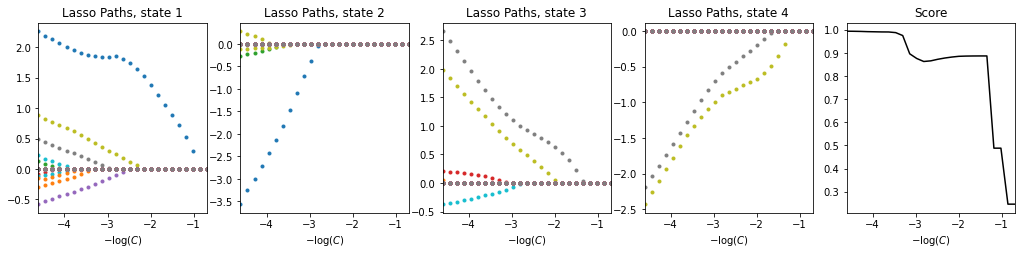

In [ ]:
descs = [f'Lasso Paths, state {idx +1}' for idx in range(coeffs_LASSO.shape[1])]
#colors = ['k', 'r--', 'g-']
fig, axes = plt.subplots(ncols = coeffs_LASSO.shape[1] + 1, figsize=(17.5,3.5))
for idx in range(coeffs_LASSO.shape[1]):
    ax = axes[idx]
    ax.plot(np.log(1/C_range), coeffs_LASSO[:,idx,:], '.')
    ax.set_xlim(np.log(1/C_range[-1]), np.log(1/C_range[0]))
    ax.set_xlabel(r"$-\log(C)$")
    ax.set_title(descs[idx])
ax = axes[-1]
ax.plot(np.log(1/C_range), CV_LASSO, 'k-')
ax.set_xlim(np.log(1/C_range[-1]), np.log(1/C_range[0]))
ax.set_xlabel(r"$-\log(C)$")
ax.set_title("Score")

In [ ]:
def get_features(C, coeffs_LASSO, C_range, features_names):
    #Find idx of C_range closer to C
    C_idx = np.argmin(np.abs(C_range - C))
    selected_coefficients = coeffs_LASSO[C_idx]
    relevant_features = []
    for state_idx, coef in enumerate(selected_coefficients):
        sparse_coef = csr_matrix(coef)
        model_idxs = sparse_coef.indices
        print(f"Features relevant to recognize state {state_idx}:")
        state_feats = []
        for feat_idx in model_idxs:
            feature = features_names[feat_idx]
            print(f'\t{feature}')
            state_feats.append((feature, feat_idx))
        relevant_features.append(state_feats)
    return relevant_features

In [ ]:
features = get_features(np.exp(2), coeffs_LASSO, C_range, features_names)
features

Features relevant to recognize state 0:
	cos_chi1-3
Features relevant to recognize state 1:
Features relevant to recognize state 2:
	sin_chi1-6
	cos_chi1-8
Features relevant to recognize state 3:
	sin_chi1-6
	cos_chi1-8


[[('cos_chi1-3', 40)],
 [],
 [('sin_chi1-6', 47), ('cos_chi1-8', 48)],
 [('sin_chi1-6', 47), ('cos_chi1-8', 48)]]

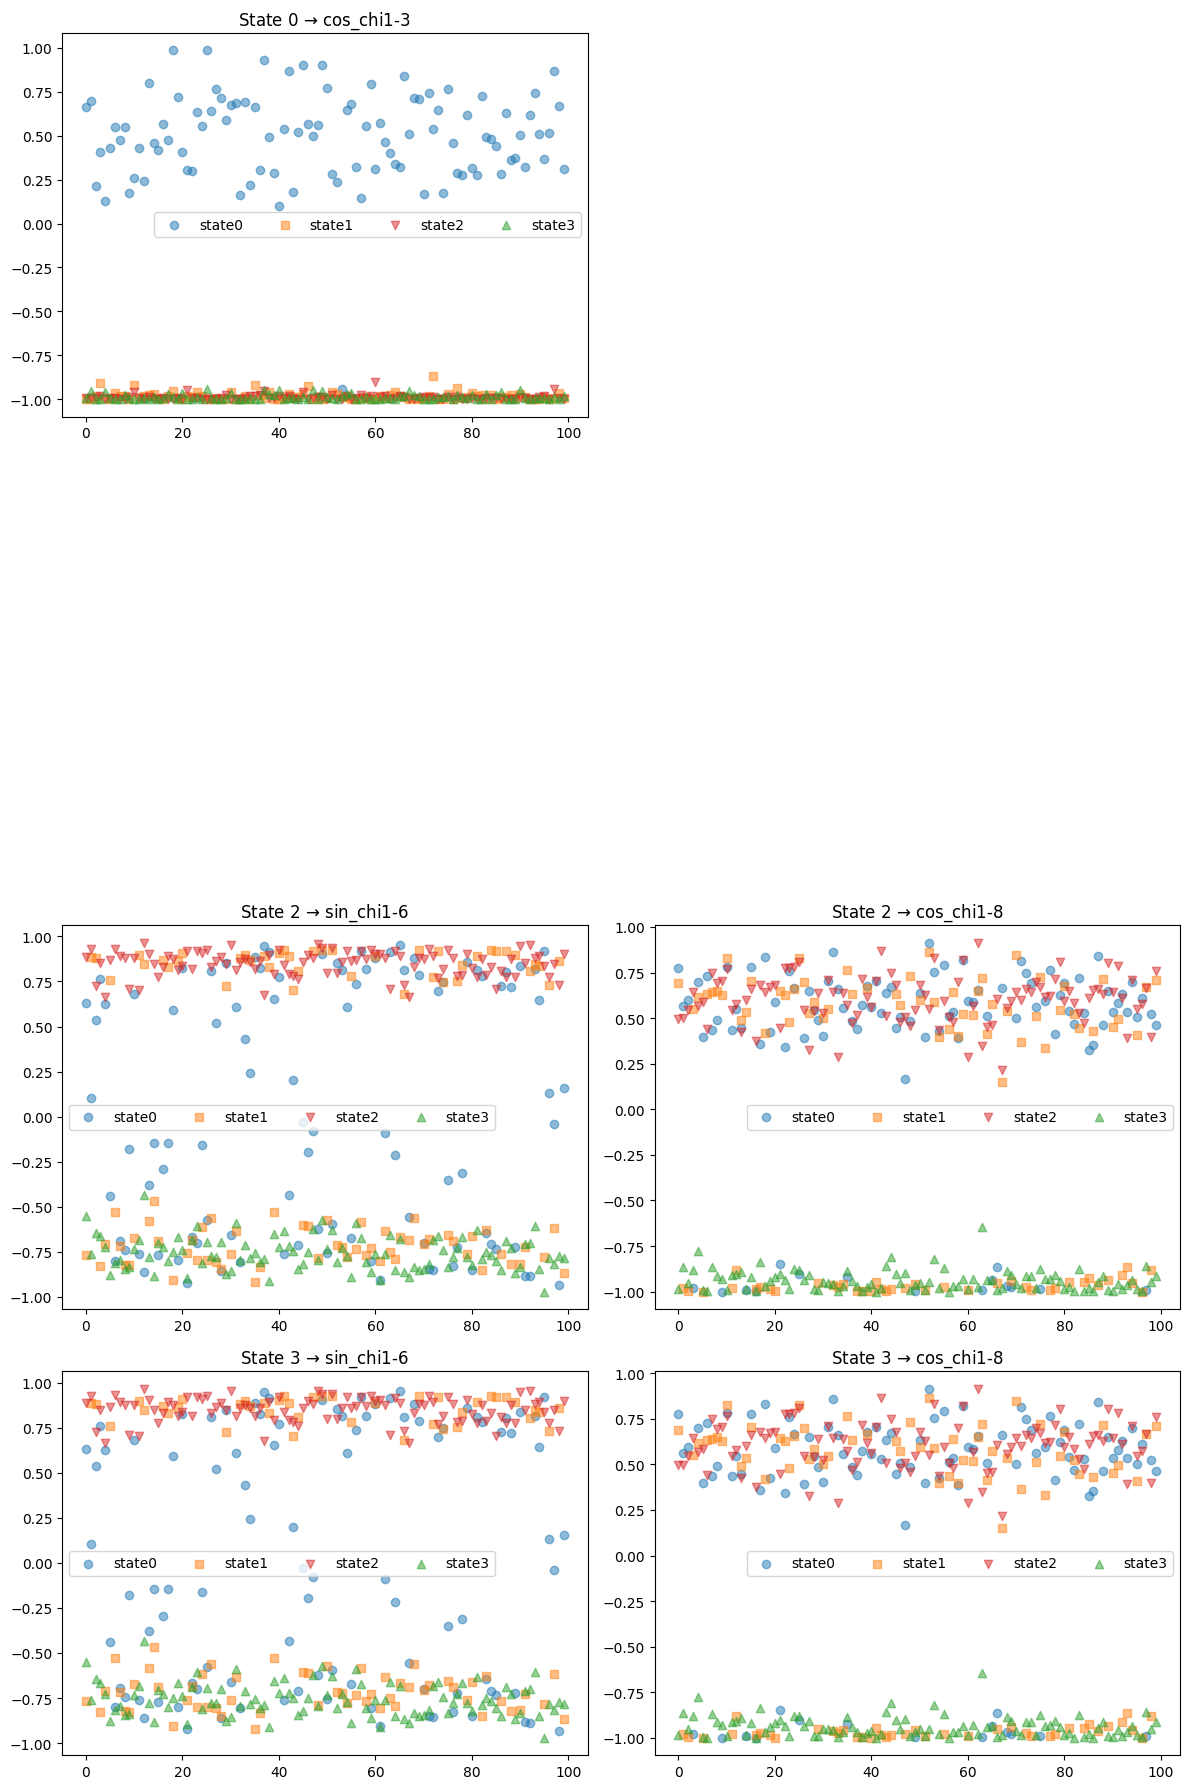

In [ ]:
#features = [['dd_32-119', 'dd_32-125'],['chi1-6', 'chi1-8'],['chi1-6', 'chi1-8'],['chi1-6', 'chi1-8']]

nrows=4
ncols=2

fig,axs=plt.subplots(nrows,ncols,figsize=(12,18),dpi=100)

colors=['tab:blue','tab:orange','tab:red','tab:green']
markers=['o','s','v','^']

for i in range(4):
    for j,feature_tuple in enumerate(features[i]):
        feature, feat_idx = feature_tuple
        ax = axs[i,j]
        ax.set_title(r'State '+str(i)+r' $\to$ '+feature)
        for k,config in enumerate(config_list):
            ax.scatter(np.arange(config.shape[0])[:100],config[:100,feat_idx],label='state'+str(k),alpha=0.5,color=colors[k],marker=markers[k])
        ax.legend(ncol=4)
        
    for j in range(len(features[i]),ncols):
        axs[i,j].axis('off')
plt.tight_layout()

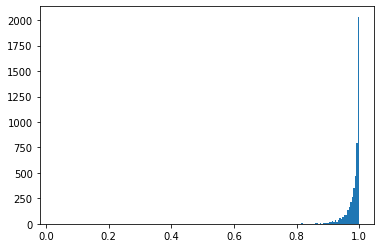

In [ ]:

plt.hist(np.abs(config_list[1][:,40]), bins=200);

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fa81218d-8afb-4a4f-8164-247b0de78a96' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>